In [1]:
# trying a simple training example
# the custom model

import torch
import torch.nn as nn
import numpy as np
from my_extension import (
    CustomLinear, 
    CustomReLU
)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [2]:
"""Define a few models for comparison, including a standard (all built in ops), custom, and mixed model
"""

bias_set = True

class CustomNeuralNet(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 hidden_size_2,
                 output_size):
        super(CustomNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = CustomLinear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class StandardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(StandardNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=bias_set)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class MixedNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(MixedNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

class TinyNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TinyNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x


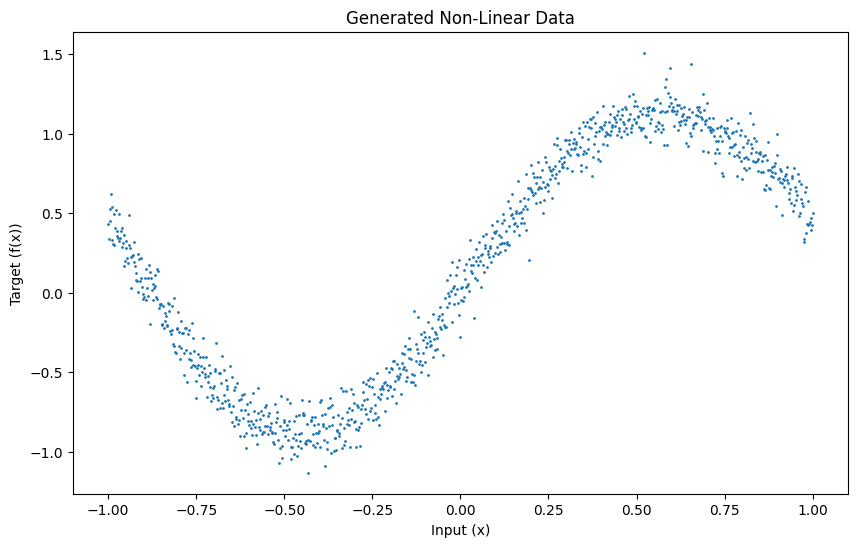

In [3]:
"""
Make some data 

In this simple example, we will set a piece of a sine wave as 
the training data, just for a non linear example. We will not
be extrapolating with the fully connected neural net so it will 
serve the purpose.
"""

num_samples = 1000  # Number of data points
x_range = [-1, 1]  # Range of x values
noise_factor = 0.1  # Noise factor for the data

# Generate input features
inputs = torch.linspace(x_range[0], x_range[1], steps=num_samples).unsqueeze(1)

# Generate targets based on the non-linear function
targets = torch.sin(1 * np.pi * inputs) + 0.5 * torch.pow(inputs, 2)

# Add noise to targets
targets_noisy = targets + torch.randn(targets.shape) * noise_factor

# Split into training and testing sets
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets_noisy, test_size=0.2)

# Calculate mean and standard deviation of the inputs
inputs_mean = train_inputs.mean()
inputs_std = train_inputs.std()

# Normalize (scale and center) the inputs
train_inputs_normalized = (train_inputs - inputs_mean) / inputs_std
test_inputs_normalized = (test_inputs - inputs_mean) / inputs_std

# Calculate mean and standard deviation of the targets
targets_mean = train_targets.mean()
targets_std = train_targets.std()

# Normalize (scale and center) the targets
train_targets_normalized = (train_targets - targets_mean) / targets_std
test_targets_normalized = (test_targets - targets_mean) / targets_std

# Plot the generated data
plt.figure(figsize=(10, 6))
plt.scatter(inputs.numpy(), targets_noisy.numpy(), s=1)
plt.title("Generated Non-Linear Data")
plt.xlabel("Input (x)")
plt.ylabel("Target (f(x))")
plt.show()



In [4]:
# move to the MPS device
train_inputs_preprocessed_mps = train_inputs_normalized.to('mps')
train_targets_preprocessed_mps = train_targets_normalized.to('mps')
test_inputs_preprocessed_mps = test_inputs_normalized.to('mps')
test_targets_preprocessed_mps = test_targets_normalized.to('mps')

In [5]:
# Initialize the networks and move to MPS device
num_features = 1
hidden_size = 300
hidden_size_2 = 100
output_size = 1

standard_model = None
standard_model = StandardNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2, 
    output_size=1
).to('mps')

custom_model = None
custom_model = CustomNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')

mixed_model = None
mixed_model = MixedNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')


tiny_model = None
tiny_model = TinyNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    output_size=output_size
).to('mps')

In [6]:
import torch.mps.profiler as pro


# set the model to the model of choice
optimizer = None 
loss = None
criterion = None

model = custom_model

# set criterion and choose adam optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Simple Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    with torch.mps.profiler.profile(mode='interval', wait_until_completed=True):
        outputs = model(train_inputs_preprocessed_mps)
        loss = criterion(outputs, train_targets_preprocessed_mps)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #pro.stop()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    # if (epoch+1) % 100 == 0:
    #     for name, param in model.named_parameters():
    #         print(f"Gradients of {name}: {param.grad}")


Epoch [10/10000], Loss: 0.2871
Epoch [20/10000], Loss: 0.1403
Epoch [30/10000], Loss: 0.0663
Epoch [40/10000], Loss: 0.0418
Epoch [50/10000], Loss: 0.0312
Epoch [60/10000], Loss: 0.0235
Epoch [70/10000], Loss: 0.0201
Epoch [80/10000], Loss: 0.0188
Epoch [90/10000], Loss: 0.0185
Epoch [100/10000], Loss: 0.0184
Epoch [110/10000], Loss: 0.0183
Epoch [120/10000], Loss: 0.0183
Epoch [130/10000], Loss: 0.0183
Epoch [140/10000], Loss: 0.0182
Epoch [150/10000], Loss: 0.0182
Epoch [160/10000], Loss: 0.0182
Epoch [170/10000], Loss: 0.0182
Epoch [180/10000], Loss: 0.0181
Epoch [190/10000], Loss: 0.0181
Epoch [200/10000], Loss: 0.0181
Epoch [210/10000], Loss: 0.0181
Epoch [220/10000], Loss: 0.0181
Epoch [230/10000], Loss: 0.0181
Epoch [240/10000], Loss: 0.0181
Epoch [250/10000], Loss: 0.0181
Epoch [260/10000], Loss: 0.0181
Epoch [270/10000], Loss: 0.0181
Epoch [280/10000], Loss: 0.0180
Epoch [290/10000], Loss: 0.0180
Epoch [300/10000], Loss: 0.0180


KeyboardInterrupt: 

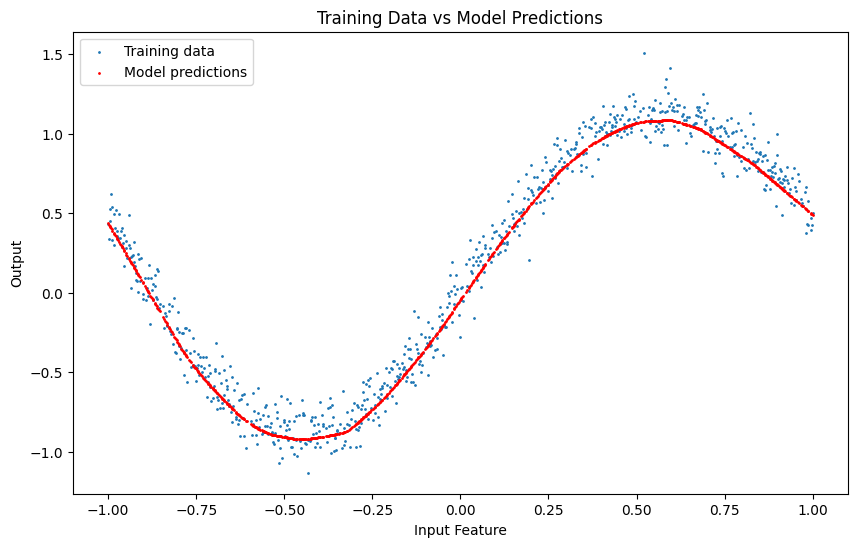

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# Assuming `train_inputs` and `train_outputs` are your training data
# And `model` is your trained model

# Move the data to the same device as the model
#train_inputs, train_outputs = train_inputs.to('mps'), train_targets.to('mps')

# Get predictions from the model
with torch.no_grad():
    predictions = model(train_inputs_preprocessed_mps)

# reverse the center scaling for the predictions
predictions = predictions.cpu()
predictions = (predictions + targets_mean) * targets_std
predictions = predictions.numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_inputs[:, 0], train_targets[:, 0], label='Training data', s=1)
plt.scatter(train_inputs[:, 0], predictions[:, 0], label='Model predictions', color='red', s=1)
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Training Data vs Model Predictions')
plt.show()


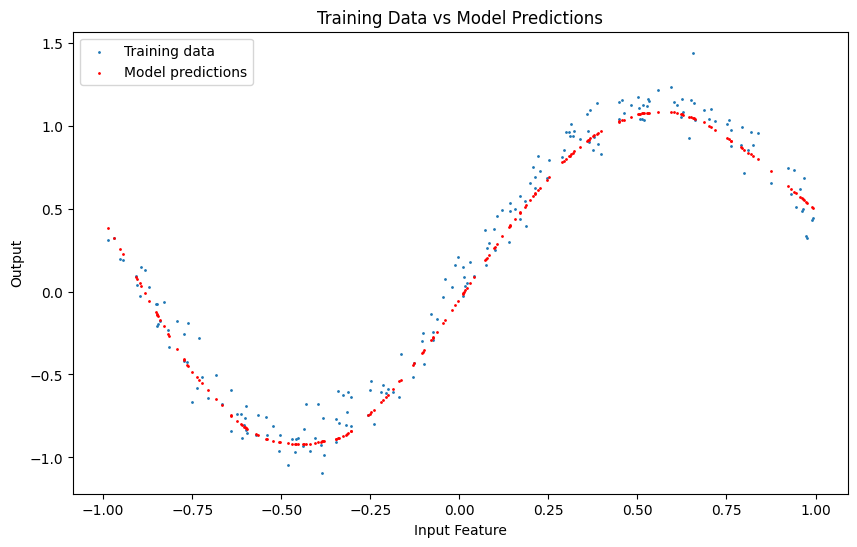

In [8]:

# Assuming `train_inputs` and `train_outputs` are your training data
# And `model` is your trained model
# Move the data to the same device as the model
#train_inputs, train_outputs = train_inputs.to('mps'), train_targets.to('mps')

# Get predictions from the model
with torch.no_grad():
    predictions = model(test_inputs_preprocessed_mps)

# reverse the center scaling for the predictions
predictions = predictions.cpu()
predictions = (predictions + targets_mean) * targets_std
predictions = predictions.numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(test_inputs[:, 0], test_targets[:, 0], label='Training data', s=1)
plt.scatter(test_inputs[:, 0], predictions[:, 0], label='Model predictions', color='red', s=1)
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Training Data vs Model Predictions')
plt.show()


In [56]:
# Inspect Gradients
for name, param in model.named_parameters():
    print(f"Gradients of {name}: {param.grad}")


Gradients of fc1.weight: tensor([[ 0.0000],
        [ 0.0000],
        [ 0.0031],
        [ 0.0006],
        [-0.0008]], device='mps:0')
Gradients of fc1.bias: tensor([ 0.0000,  0.0000, -0.0022, -0.0004, -0.0007], device='mps:0')
Gradients of fc2.weight: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0022,  0.0012,  0.0007],
        [ 0.0000,  0.0000, -0.0018, -0.0001, -0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0005,  0.0000,  0.0012]], device='mps:0')
Gradients of fc2.bias: tensor([ 0.0000, -0.0008, -0.0014,  0.0000,  0.0003], device='mps:0')
Gradients of fc3.weight: tensor([[ 0.0000, -0.0048,  0.0006,  0.0000,  0.0002]], device='mps:0')
Gradients of fc3.bias: tensor([0.0927], device='mps:0')


In [26]:
# Inspect Parameters
for name, param in model.named_parameters():
    print(f"Values of {name}: {param}")


Values of fc1.weight: Parameter containing:
tensor([[ 0.1360],
        [ 0.9674],
        [-1.1944],
        [-1.2698],
        [-1.4850]], device='mps:0', requires_grad=True)
Values of fc1.bias: Parameter containing:
tensor([-1.3885, -1.0289,  2.0568,  1.9579,  2.0204], device='mps:0',
       requires_grad=True)
Values of fc2.weight: Parameter containing:
tensor([[-0.1133,  0.1705,  0.9194,  0.9520,  1.0655],
        [ 0.3961,  0.4371, -0.0853,  0.2873, -0.3558],
        [-0.7498,  0.1946, -0.0791, -0.2562, -0.0978],
        [ 0.3634, -0.0381,  0.4772, -0.1316, -0.3436],
        [ 0.7696,  0.5694, -0.3407,  0.3640, -0.0447]], device='mps:0',
       requires_grad=True)
Values of fc2.bias: Parameter containing:
tensor([ 1.8407, -1.3476,  1.3586, -1.7185, -1.1064], device='mps:0',
       requires_grad=True)
Values of fc3.weight: Parameter containing:
tensor([[-0.1051,  1.3571, -0.5630,  0.8001,  0.6373]], device='mps:0',
       requires_grad=True)
Values of fc3.bias: Parameter containing